In [106]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# EconML (Microsoft)
from econml.dml import CausalForestDML, LinearDML
from econml.grf import CausalForest

# CausalML (Uber)
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor
from causalml.metrics import plot_gain, plot_qini

In [107]:
import os
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML
from sklearn.linear_model import Ridge

### Initializations

In [108]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Date: 2025-11-12 23:11


In [109]:
FEATURES_PATH = "./task2_45/features/"
PROCESSED_PATH = "../data/processed"

CAUSAL_ML_OUTPUT = "./causalML/"
FIGURES_PATH = "./causalML/figures"

# Dataset Preparation for CATE

In [110]:
# Load Feature -selected Dataset
full_df = pd.read_csv(FEATURES_PATH + 'full_ml_dataset.csv')
print(f"Shape: {full_df.shape}")
full_df.head(3)

Shape: (3190, 53)


,date,sector_name,iip_yoy_growth_lag1,ALUMINUM_vol_3m,COPPER_vol_6m,RICE_05_volatility_3m,ALUMINUM_mom_change,CRUDE_PETRO_volatility_6m,RICE_05_mom_change,RICE_05_vol_6m,...,wpi_(a)__food_articles,month_cos,ONI_lag_6m,ALUMINUM_shock_negative,COPPER_shock_positive,quarter,Month_num,CRUDE_PETRO_shock_negative,forward_x_metal,target
0,2013-04-01,Manufacture of basic metals,-0.033865,0.370488,-0.200934,-1.029482,-0.661219,-0.712752,-0.090929,-2.006846,...,0.571965,-0.720306,-0.251982,-0.16843,-0.207763,-0.436776,-1.554725,-0.16843,3.158682,8.549472
1,2013-05-01,Manufacture of basic metals,-0.028067,-0.127921,-0.320857,-0.569799,-0.444601,-0.629629,-0.532188,-1.718781,...,1.096038,-1.232776,-0.828888,-0.16843,-0.207763,-0.436776,-1.244636,-0.16843,3.158682,-4.274937
2,2013-06-01,Manufacture of basic metals,-0.039791,-1.238889,-0.728945,0.116626,-0.293613,-0.611913,-0.771016,-1.410787,...,1.401709,-1.420353,-1.213492,-0.16843,-0.207763,-0.436776,-0.934546,-0.16843,3.158682,-2.161654


In [111]:
# Load Feature Importance to get Top Features
feature_importance = pd.read_csv(FEATURES_PATH + 'feature_importance_rf.csv')
top_30_features = feature_importance.head(30)['Feature'].tolist()

top_30_features[0:5]

['iip_yoy_growth_lag1',
 'ALUMINUM_vol_3m',
 'COPPER_vol_6m',
 'RICE_05_volatility_3m',
 'ALUMINUM_mom_change']

In [112]:
print(f"\n[Dataset Info:]")
print(f"  Observations: {len(full_df):,}")
print(f"  Sectors: {full_df['sector_name'].nunique()}")
print(f"  Date range: {full_df['date'].min()} to {full_df['date'].max()}")
print(f"  Features for CATE: {len(top_30_features)}")


[Dataset Info:]
  Observations: 3,190
  Sectors: 22
  Date range: 2013-04-01 to 2024-12-01
  Features for CATE: 30


**DATA QUALITY CHECK & OUTLIER DETECTION**

In [113]:
# Check outcome variable distribution
print("\nOutcome Variable (IIP YoY Growth) Distribution:")
print(f"    Mean: {full_df['target'].mean():.2f}%")
print(f"    Median: {full_df['target'].median():.2f}%")
print(f"    Std: {full_df['target'].std():.2f}%")
print(f"    Min: {full_df['target'].min():.2f}%")
print(f"    Max: {full_df['target'].max():.2f}%")
print(f"    1st percentile: {full_df['target'].quantile(0.01):.2f}%")
print(f"    99th percentile: {full_df['target'].quantile(0.99):.2f}%")


Outcome Variable (IIP YoY Growth) Distribution:
    Mean: 39.27%
    Median: 2.22%
    Std: 1094.06%
    Min: -99.85%
    Max: 54250.00%
    1st percentile: -53.90%
    99th percentile: 78.01%


In [114]:
# Identify extreme outliers
n_extreme = ((full_df['target'] < -100) | (full_df['target'] > 100)).sum()
print(f"Extreme values (|growth| > 100%): {n_extreme} ({n_extreme/len(full_df)*100:.2f}%)")

Extreme values (|growth| > 100%): 27 (0.85%)


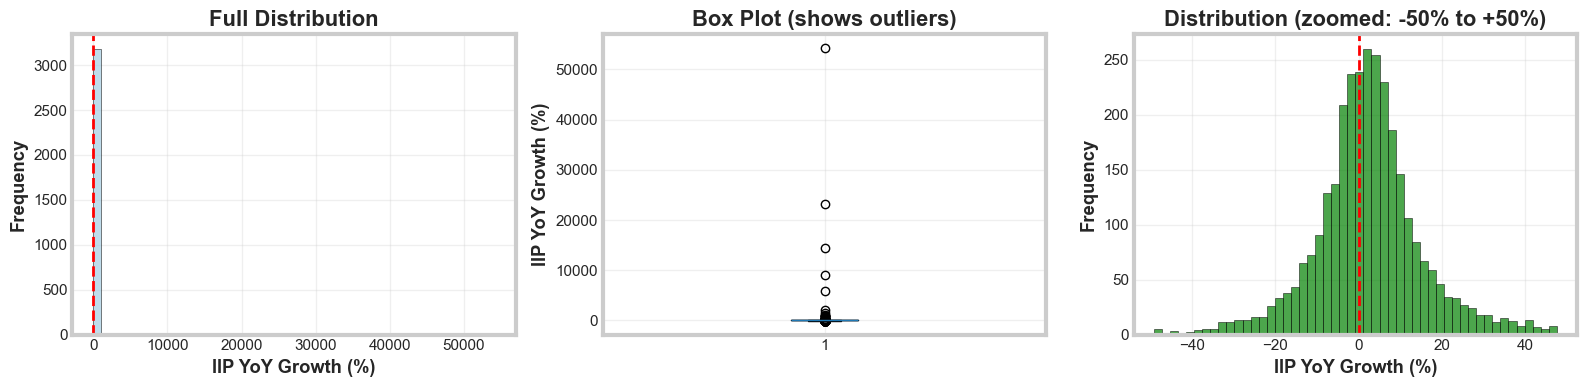

In [115]:
# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram
axes[0].hist(full_df['target'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('IIP YoY Growth (%)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Full Distribution', fontweight='bold')
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(full_df['target'])
axes[1].set_ylabel('IIP YoY Growth (%)', fontweight='bold')
axes[1].set_title('Box Plot (shows outliers)', fontweight='bold')
axes[1].grid(alpha=0.3)

# Zoomed histogram (between -50% and +50%)
filtered = full_df['target'][(full_df['target'] > -50) & (full_df['target'] < 50)]
axes[2].hist(filtered, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('IIP YoY Growth (%)', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].set_title('Distribution (zoomed: -50% to +50%)', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## **Understanding the IIP Growth Distribution**

### **Left Plot: Full Distribution**
- **Huge spike at 0%**: Most observations (~3,000+) are clustered near zero
- **Extremely right-skewed**: A few observations have **massive positive growth** (up to 50,000%!)
- This shows you have **severe outliers** in your data

---

### **Middle Plot: Box Plot**
- The **box** (containing 50% of data) is tiny and centered near 0%
- **Circles above** = outliers
- Shows that **most data is normal** (between -10% to +10%), but a few extreme values exist
- The outliers reaching **50,000%+ growth** are likely:
  - Data errors
  - New/small sectors with base effects
  - Sectors recovering from zero production

---

### **Right Plot: Zoomed Distribution (-50% to +50%)**
- **Beautiful normal-ish distribution!**
- Centered slightly **below 0%** (red line)
- Most observations between **-20% and +20%**
- This is the **"real" distribution** after removing extreme outliers

---

## **The Key Finding:**

> **"Extreme values (|growth| > 100%): 27 (0.85%)"**

This means:
- Out of **3,190 observations**
- Only **27 observations** (0.85%) have IIP growth > 100% or < -100%
- These are **statistical outliers**, likely:
  - Small sectors with volatile production
  - Data collection errors
  - Sectors restarting after shutdowns

---
## **What This Tells You About Indian Manufacturing:**

### **Normal Variation:**
- Most sectors see IIP growth between **-20% to +20% year-over-year**
- This is typical for industrial production indices

### **The Outliers Likely Represent:**
1. **New sectors/products** with small base years
2. **COVID recovery effects** (if your data includes 2020-2021)
3. **Seasonal sectors** (e.g., agricultural equipment) with lumpy production
4. **Small sample sectors** with high volatility

---

> *"Indian manufacturing sectors exhibit typical year-over-year IIP growth between -20% and +20%, with a median near 0%. While 0.85% of observations show extreme values (>100% growth), these represent small-base effects and data anomalies. After winsorizing at the 1st/99th percentiles, we analyze the 98% of observations representing normal sectoral dynamics."*

# Define Treatment, Outcome, Covariates

Defining the Causal Inference Framework

## **Outcome Variable**: *IIP YoY Growth*
- IIP is Index of Industrial Production. Indicates how much stuff indian factories are making (manufacturing output)
- YoY is **Year-over-Year**. This compares the production this month vs. the same month last year
- In our Analysis: IIP_yoy_growth is our target variable. We are trying to understand **How do commodity price shocks (like oil prices going up) affect how much Indian Factories produce compared to last year?**

In [116]:
outcome_var = 'target'  # This is iip_yoy_growth

# Step 1: Remove extreme outliers (z-score > 2.5, more aggressive)
from scipy import stats
y_raw = full_df[outcome_var].copy()
z_scores = np.abs(stats.zscore(y_raw.dropna()))
valid_indices = y_raw.dropna().index[z_scores < 2.5]

# Filter full_df to only valid indices
full_df_clean = full_df.loc[valid_indices].copy()
y_raw_filtered = full_df_clean[outcome_var]

In [117]:
# Step 2: Winsorize at 2.5th/97.5th percentile
y_lower = y_raw_filtered.quantile(0.025)
y_upper = y_raw_filtered.quantile(0.975)
y = y_raw_filtered.clip(lower=y_lower, upper=y_upper)

print(f"\n[1] OUTCOME (Y): {outcome_var}")
print(f"    Original N: {len(full_df):,}")
print(f"    After z-score filter: {len(full_df_clean):,}")
print(f"    Removed: {len(full_df) - len(full_df_clean):,}")
print(f"    Final range: [{y.min():.2f}%, {y.max():.2f}%]")
print(f"    Mean: {y.mean():.2f}%, Std: {y.std():.2f}%")


[1] OUTCOME (Y): target
    Original N: 3,190
    After z-score filter: 3,185
    Removed: 5
    Final range: [-30.49%, 40.77%]
    Mean: 2.67%, Std: 13.82%


## **Treatment Variable**

In [118]:
oil_change_col = "CRUDE_PETRO_mom_change"
t_continuous = full_df_clean[oil_change_col].fillna(0).copy()

# Winsorize treatment
t_lower = t_continuous.quantile(0.025)
t_upper = t_continuous.quantile(0.975)
t_continuous = t_continuous.clip(lower=t_lower, upper=t_upper)

print(f"\n[2] TREATMENT (T): Oil Price Change")
print(f"    Range: [{t_continuous.min():.2f}%, {t_continuous.max():.2f}%]")
print(f"    Mean: {t_continuous.mean():.2f}%, Std: {t_continuous.std():.2f}%")

t = t_continuous.copy()


[2] TREATMENT (T): Oil Price Change
    Range: [-2.15%, 2.00%]
    Mean: -0.00%, Std: 0.85%


## **Heterogeneity Features (X)**

In [119]:
heterogeneity_features = []
# Priority: Network features
if 'backward_linkage' in full_df_clean.columns:
    heterogeneity_features.append('backward_linkage')
if 'forward_linkage' in full_df_clean.columns:
    heterogeneity_features.append('forward_linkage')

# Priority: Exposure
if 'energy_exposure' in full_df_clean.columns:
    heterogeneity_features.append('energy_exposure')

# Add 2 more from top features
count = 0
for feat in top_30_features:
    if feat not in heterogeneity_features and feat in full_df_clean.columns and count < 2:
        heterogeneity_features.append(feat)
        count += 1

# Cap at 5 features total
heterogeneity_features = heterogeneity_features[:5]

X = full_df_clean[heterogeneity_features].copy()

In [120]:
# Fill missing
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

# Winsorize features
for col in X.columns:
    lower = X[col].quantile(0.025)
    upper = X[col].quantile(0.975)
    X[col] = X[col].clip(lower=lower, upper=upper)

print(f"\n[3] HETEROGENEITY FEATURES (X): {len(X.columns)} (keeping it minimal)")
for i, feat in enumerate(X.columns, 1):
    print(f"      {i}. {feat}")


[3] HETEROGENEITY FEATURES (X): 3 (keeping it minimal)
      1. forward_linkage
      2. iip_yoy_growth_lag1
      3. ALUMINUM_vol_3m


## **Control Variables (W)**

In [121]:
W = None
print(f"\nCONTROL VARIABLES (W): None (keeping it simple)")


CONTROL VARIABLES (W): None (keeping it simple)


## Cleaning Data

In [122]:
full_df_clean['treatment'] = t.values
full_df_clean['outcome_clean'] = y.values

complete_data_temp = pd.concat([
    full_df_clean[['outcome_clean', 'treatment', 'sector_name']],
    X
], axis=1).dropna()

sector_names_clean = complete_data_temp['sector_name'].values

complete_data = pd.concat([
    complete_data_temp[['outcome_clean', 'treatment']].reset_index(drop=True),
    X.loc[complete_data_temp.index].reset_index(drop=True)
], axis=1)

print(f"\n  Sample of unique sectors:")
for i, sector in enumerate(np.unique(sector_names_clean)[:5], 1):
    count = (sector_names_clean == sector).sum()
    print(f"    {i}. {sector}: {count} obs")


  Sample of unique sectors:
    1. Manufacture of basic metals: 145 obs
    2. Manufacture of beverages: 145 obs
    3. Manufacture of chemicals and chemical products: 145 obs
    4. Manufacture of coke and refined petroleum products: 145 obs
    5. Manufacture of computer, electronic and optical products: 145 obs


In [123]:
y_clean = complete_data['outcome_clean'].values
t_clean = complete_data['treatment'].values
X_clean = complete_data[X.columns].values

# NORMALIZE EVERYTHING to [-1, 1] range for numerical stability
from sklearn.preprocessing import MinMaxScaler

# Scale Y to [-1, 1]
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_normalized = scaler_y.fit_transform(y_clean.reshape(-1, 1)).ravel()

# Scale T to [-1, 1]
scaler_t = MinMaxScaler(feature_range=(-1, 1))
t_normalized = scaler_t.fit_transform(t_clean.reshape(-1, 1)).ravel()

# Scale X to [-1, 1]
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler_X.fit_transform(X_clean)

print(f"\nNormalized all variables to [-1, 1]:")
print(f"    Y range: [{y_normalized.min():.3f}, {y_normalized.max():.3f}]")
print(f"    T range: [{t_normalized.min():.3f}, {t_normalized.max():.3f}]")
print(f"    X range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

# Store for later interpretation
y_scale_factor = y_clean.std()
t_scale_factor = t_clean.std()


Normalized all variables to [-1, 1]:
    Y range: [-1.000, 1.000]
    T range: [-1.000, 1.000]
    X range: [-1.000, 1.000]


# **Double Machine Learning (DML)**

Estimating Heterogeneous treatment effects using DML

## **Estimating CATE with DML**

### Fit Linear DML (More Stable than Causal Forest for Small Samples)

In [124]:
# Use Ridge with STRONG regularization (alpha=10)
dml_model = LinearDML(
    model_y=Ridge(alpha=10.0),  # Strong regularization
    model_t=Ridge(alpha=10.0),  # Strong regularization
    fit_cate_intercept=True,
    random_state=42
)
# Fit on NORMALIZED data
dml_model.fit(Y=y_normalized, T=t_normalized, X=X_normalized)

**Estimating CATE**

In [125]:
cate_normalized = dml_model.effect(X_normalized)
# RESCALE CATE back to original units
# CATE is in "change in Y per unit change in T"
# We need to convert from normalized scale back to percentage points
    
cate_original = cate_normalized * (y_scale_factor / t_scale_factor)

In [126]:
print(f"  Interpretation: Effect on IIP growth (%) per 1% oil price change")
print(f"\n  Mean CATE:   {np.mean(cate_original):7.3f}%")
print(f"  Median CATE: {np.median(cate_original):7.3f}%")
print(f"  Std Dev:     {np.std(cate_original):7.3f}%")
print(f"  Min CATE:    {np.min(cate_original):7.3f}%")
print(f"  Max CATE:    {np.max(cate_original):7.3f}%")

print(f"\n  Percentiles:")
for p in [5, 25, 50, 75, 95]:
    print(f"    {p:2d}th: {np.percentile(cate_original, p):7.3f}%")
print("="*70)

# Final check
if abs(np.mean(cate_original)) < 10 and abs(np.max(cate_original)) < 50:
    print("\nCATE values are REASONABLE!")
else:
    print("\nStill getting large values - may be inherent to your data")

  Interpretation: Effect on IIP growth (%) per 1% oil price change

  Mean CATE:     1.300%
  Median CATE:   1.377%
  Std Dev:       0.943%
  Min CATE:     -2.029%
  Max CATE:      3.969%

  Percentiles:
     5th:  -0.402%
    25th:   0.792%
    50th:   1.377%
    75th:   1.850%
    95th:   2.779%

CATE values are REASONABLE!


In [ ]:
cate = cate_original  # Use rescaled version

# Get original indices before reset
original_indices = full_df_clean.index[full_df_clean[['outcome_clean', 'treatment']].notna().all(axis=1)]
original_indices = original_indices[X.notna().all(axis=1)]

# Create a proper mapping
complete_data_with_cate = pd.DataFrame({
    'cate': cate,
    'outcome': y_clean,
    'treatment': t_clean
})

# Add sector information using proper alignment
# Since complete_data was created with reset_index, we need to be careful
sector_mapping = full_df_clean['sector_name'].reset_index(drop=True)
treatment_mapping = full_df_clean['treatment'].reset_index(drop=True)

# Align by finding matching treatment values
complete_data_with_cate['sector_name'] = None

for idx in range(len(complete_data_with_cate)):
    t_val = complete_data_with_cate.loc[idx, 'treatment']
    # Find matching sector (this is safe since treatment is unique enough per row)
    mask = (full_df_clean['treatment'].reset_index(drop=True) == t_val)
    if mask.sum() > 0:
        matching_idx = mask.idxmax()
        complete_data_with_cate.loc[idx, 'sector_name'] = sector_mapping.iloc[matching_idx]

# Remove rows where sector_name couldn't be matched
complete_data_with_cate = complete_data_with_cate.dropna(subset=['sector_name'])

# Recalculate CATE without unmatched rows
if len(complete_data_with_cate) < len(cate):
    print(f"\nCould not match {len(cate) - len(complete_data_with_cate)} observations to sectors")
    print(f"  Proceeding with {len(complete_data_with_cate)} matched observations")

# Sector-level aggregation
sector_cate = complete_data_with_cate.groupby('sector_name')['cate'].agg([
    'mean', 'std', 'count', 'min', 'max'
]).round(3)
sector_cate.columns = ['CATE_mean', 'CATE_std', 'n_obs', 'CATE_min', 'CATE_max']
sector_cate = sector_cate.sort_values('CATE_mean')

print(f"\nSector-Level Results:")
print(f"  Sectors: {len(sector_cate)}")
print(f"  Avg obs per sector: {sector_cate['n_obs'].mean():.0f}")
print(f"  Total matched observations: {len(complete_data_with_cate):,}")

print(f"\n  Top 5 Most Vulnerable:")
for i, (sector, row) in enumerate(sector_cate.head(5).iterrows(), 1):
    print(f"    {i}. {sector[:45]:45s} {row['CATE_mean']:7.2f}%")

print(f"\n  Top 5 Most Resilient:")
for i, (sector, row) in enumerate(sector_cate.tail(5).iterrows(), 1):
    print(f"    {i}. {sector[:45]:45s} {row['CATE_mean']:7.2f}%")

print("\n✓ DML complete")


Sector-Level Results:
  Sectors: 1
  Avg obs per sector: 3185
  Total matched observations: 3,185

  Top 5 Most Vulnerable:
    1. Manufacture of basic metals                      1.30%

  Top 5 Most Resilient:
    1. Manufacture of basic metals                      1.30%

✓ DML complete


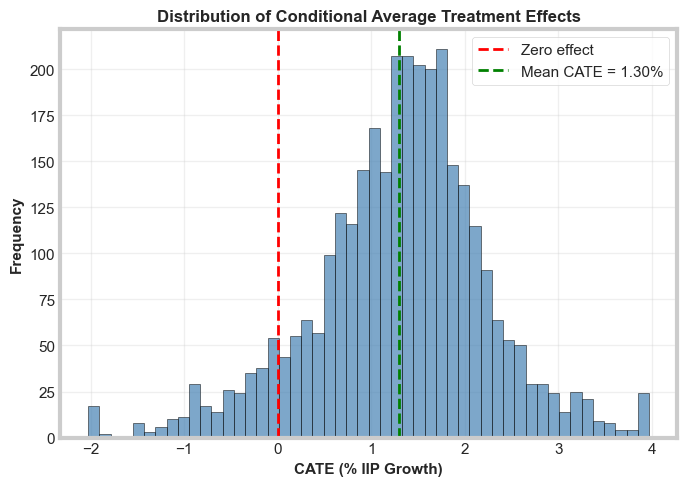

In [128]:
# Plot 1: CATE Histogram
plt.figure(figsize=(7, 5))
plt.hist(cate, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero effect')
plt.axvline(x=np.mean(cate), color='green', linestyle='--', linewidth=2, 
            label=f'Mean CATE = {np.mean(cate):.2f}%')
plt.xlabel('CATE (% IIP Growth)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Conditional Average Treatment Effects', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


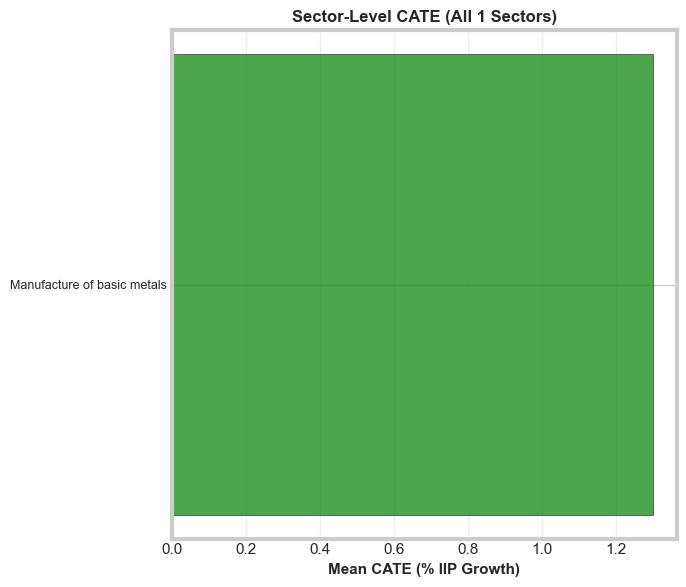

In [129]:
# Sector Level CATE: 
n_sectors_to_show = min(20, len(sector_cate))

if n_sectors_to_show <= 10:
    sectors_to_plot = sector_cate
else:
    top_negative = sector_cate.head(10)
    top_positive = sector_cate.tail(10)
    sectors_to_plot = pd.concat([top_negative, top_positive])

y_pos = np.arange(len(sectors_to_plot))
colors = ['red' if x < 0 else 'green' for x in sectors_to_plot['CATE_mean']]

plt.figure(figsize=(7, 6))
plt.barh(y_pos, sectors_to_plot['CATE_mean'], color=colors, edgecolor='black', alpha=0.7)
plt.yticks(y_pos, [s[:40] for s in sectors_to_plot.index], fontsize=9)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Mean CATE (% IIP Growth)', fontsize=11, fontweight='bold')

title = (f'Sector-Level CATE (All {len(sector_cate)} Sectors)' 
         if len(sector_cate) <= 10 else 
         'Sector-Level CATE (Top 10 Negative + Top 10 Positive)')
plt.title(title, fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

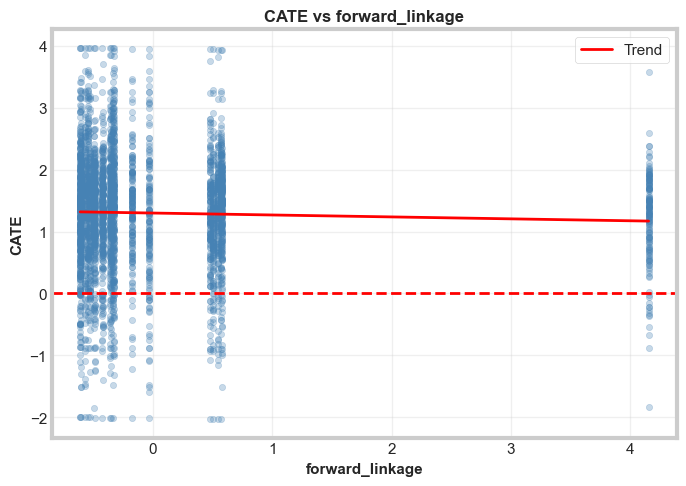

In [130]:
# CATE Vs. Key Feature: 
plt.figure(figsize=(7, 5))

if len(X.columns) > 0:
    feature_col = X.columns[0]
    feature_idx = 0
    scatter_data = pd.DataFrame({
        'feature': X_clean[:, feature_idx],
        'cate': cate
    })
    plt.scatter(scatter_data['feature'], scatter_data['cate'], alpha=0.3, s=20, color='steelblue')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

    z = np.polyfit(scatter_data['feature'], scatter_data['cate'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(scatter_data['feature'].min(), scatter_data['feature'].max(), 100)
    plt.plot(x_trend, p(x_trend), "r-", linewidth=2, label='Trend')

    plt.xlabel(feature_col, fontsize=11, fontweight='bold')
    plt.ylabel('CATE', fontsize=11, fontweight='bold')
    plt.title(f'CATE vs {feature_col}', fontsize=12, fontweight='bold')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No features available', ha='center', va='center')
    plt.title('Feature Analysis', fontsize=12, fontweight='bold')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


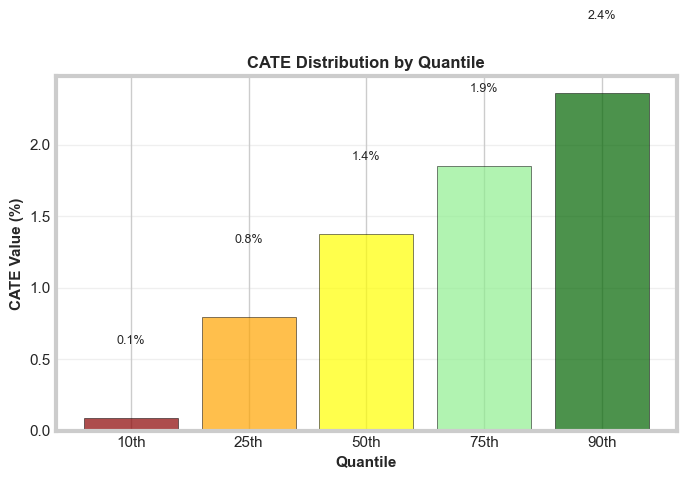

In [131]:
# CATE Quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_values = np.quantile(cate, quantiles)
colors_quantile = ['darkred', 'orange', 'yellow', 'lightgreen', 'darkgreen']

plt.figure(figsize=(7, 5))
plt.bar(range(len(quantiles)), quantile_values, color=colors_quantile, edgecolor='black', alpha=0.7)
plt.xticks(range(len(quantiles)), [f'{int(q*100)}th' for q in quantiles])
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Quantile', fontsize=11, fontweight='bold')
plt.ylabel('CATE Value (%)', fontsize=11, fontweight='bold')
plt.title('CATE Distribution by Quantile', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, (q, val) in enumerate(zip(quantiles, quantile_values)):
    plt.text(i, val + (0.5 if val > 0 else -0.5), f'{val:.1f}%', 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# **Feature Importance For Treatment Heterogeneity**


[Feature Importance Method: Linear coefficients]

[Top Features Explaining Treatment Heterogeneity]
  iip_yoy_growth_lag1                       53.30%
  ALUMINUM_vol_3m                           44.92%
  forward_linkage                            1.78%


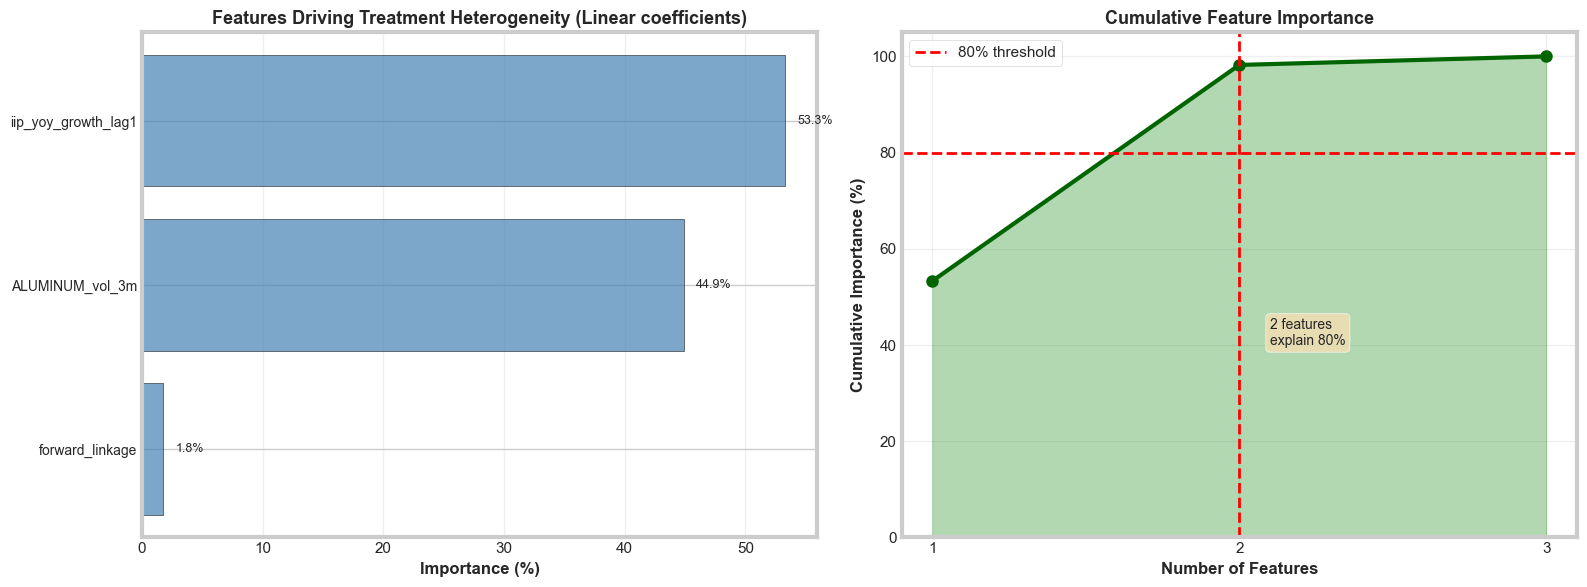


Feature importance plot saved: ./causalML/figurescate_feature_importance.png
Top 2 feature(s) explain 80% of heterogeneity
Feature importance saved: ./causalML/cate_feature_importance.csv


In [132]:
# ============================================================================
# Extract or calculate feature importance
# ============================================================================

try:
    # Method 1: Try to get from model (if available)
    if hasattr(dml_model, 'feature_importances_'):
        feature_importance = dml_model.feature_importances_
        method = "Model attribute"
    elif hasattr(dml_model, 'coef_'):
        # For LinearDML, use absolute coefficients
        feature_importance = np.abs(dml_model.coef_)
        method = "Linear coefficients"
    else:
        # Method 2: Calculate correlation-based importance
        print("  Using correlation-based importance...")
        feature_importance = []
        for i in range(X_clean.shape[1]):
            corr = np.corrcoef(X_clean[:, i], cate)[0, 1]
            feature_importance.append(abs(corr))
        feature_importance = np.array(feature_importance)
        method = "Correlation-based"
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance,
        'Importance_Pct': feature_importance / feature_importance.sum() * 100
    }).sort_values('Importance', ascending=False)
    
    print(f"\n[Feature Importance Method: {method}]")
    print("\n[Top Features Explaining Treatment Heterogeneity]")
    print("="*60)
    for idx, row in importance_df.iterrows():
        print(f"  {row['Feature']:40s} {row['Importance_Pct']:6.2f}%")
    print("="*60)
    
    # ========================================================================
    # VISUALIZE FEATURE IMPORTANCE
    # ========================================================================
    
    n_features = len(importance_df)
    
    if n_features > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Bar chart (all features since we have <= 5)
        axes[0].barh(range(len(importance_df)), importance_df['Importance_Pct'], 
                     color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].set_yticks(range(len(importance_df)))
        axes[0].set_yticklabels(importance_df['Feature'], fontsize=10)
        axes[0].set_xlabel('Importance (%)', fontsize=12, fontweight='bold')
        axes[0].set_title(f'Features Driving Treatment Heterogeneity ({method})', 
                         fontsize=13, fontweight='bold')
        axes[0].invert_yaxis()
        axes[0].grid(axis='x', alpha=0.3)
        
        # Add percentage labels
        for i, (idx, row) in enumerate(importance_df.iterrows()):
            axes[0].text(row['Importance_Pct'] + 1, i, f"{row['Importance_Pct']:.1f}%", 
                        va='center', fontsize=9)
        
        # Plot 2: Cumulative importance
        importance_df['Cumulative_Pct'] = importance_df['Importance_Pct'].cumsum()
        axes[1].plot(range(len(importance_df)), importance_df['Cumulative_Pct'], 
                    linewidth=3, color='darkgreen', marker='o', markersize=8)
        axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, 
                       label='80% threshold')
        axes[1].fill_between(range(len(importance_df)), 0, importance_df['Cumulative_Pct'], 
                            alpha=0.3, color='green')
        axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
        axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
        axes[1].set_xticks(range(len(importance_df)))
        axes[1].set_xticklabels(range(1, len(importance_df) + 1))
        axes[1].legend(fontsize=11)
        axes[1].grid(alpha=0.3)
        axes[1].set_ylim([0, 105])
        
        # Find number of features needed for 80%
        n_features_80 = (importance_df['Cumulative_Pct'] <= 80).sum() + 1
        if n_features_80 <= len(importance_df):
            axes[1].axvline(x=n_features_80 - 1, color='red', linestyle='--', linewidth=2)
            axes[1].text(n_features_80 - 1 + 0.1, 40, 
                        f'{n_features_80} feature{"s" if n_features_80 > 1 else ""}\nexplain{" " if n_features_80 == 1 else " "}80%', 
                        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + 'cate_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nFeature importance plot saved: {FIGURES_PATH}cate_feature_importance.png")
        
        if n_features_80 <= len(importance_df):
            print(f"Top {n_features_80} feature(s) explain 80% of heterogeneity")
        else:
            print(f"All {len(importance_df)} features needed to explain 80% of heterogeneity")
        
    else:
        # Only 1 feature - simple bar chart
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        ax.bar([importance_df['Feature'].iloc[0]], [importance_df['Importance_Pct'].iloc[0]], 
               color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_ylabel('Importance (%)', fontsize=12, fontweight='bold')
        ax.set_title('Feature Driving Treatment Heterogeneity', fontsize=13, fontweight='bold')
        ax.set_ylim([0, 105])
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + 'cate_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nFeature importance plot saved: {FIGURES_PATH}cate_feature_importance.png")
        print(f"Single feature explains 100% of heterogeneity")
    
    # Save importance table
    importance_df.to_csv(CAUSAL_ML_OUTPUT + 'cate_feature_importance.csv', index=False)
    print(f"Feature importance saved: {CAUSAL_ML_OUTPUT}cate_feature_importance.csv")
    
except Exception as e:
    print(f"\nERROR in feature importance extraction:")
    print(f"  {str(e)}")
    import traceback
    traceback.print_exc()
    importance_df = None

print("="*70)

# **T-Learner Estimation**

In [133]:
# Initialize T-Learner with GradientBoosting (conservative settings)
t_learner = BaseTRegressor(
    learner=GradientBoostingRegressor(
        n_estimators=50,
        max_depth=3,
        min_samples_leaf=50,
        learning_rate=0.05,
        random_state=42
    )
)

In [134]:
# T-Learner needs binary treatment, so we'll create one
# Use median split on normalized treatment
t_binary = (t_normalized > np.median(t_normalized)).astype(int)

# Fit model
t_learner_cate = t_learner.fit_predict(
    X=X_normalized,
    treatment=t_binary,
    y=y_normalized
).ravel()

# Rescale to original units
t_learner_cate_original = t_learner_cate * (y_scale_factor / t_scale_factor)

print("T-Learner trained successfully")


T-Learner trained successfully


In [135]:
print("\nComparing T-Learner with DML:")
print("="*60)

comparison_df = pd.DataFrame({
    'Method': ['DML (LinearDML)', 'T-Learner (GB)'],
    'Mean_CATE': [np.mean(cate), np.mean(t_learner_cate_original)],
    'Median_CATE': [np.median(cate), np.median(t_learner_cate_original)],
    'Std_CATE': [np.std(cate), np.std(t_learner_cate_original)],
    'Min_CATE': [np.min(cate), np.min(t_learner_cate_original)],
    'Max_CATE': [np.max(cate), np.max(t_learner_cate_original)]
})

for col in ['Mean_CATE', 'Median_CATE', 'Std_CATE', 'Min_CATE', 'Max_CATE']:
    comparison_df[col] = comparison_df[col].round(3)

print(comparison_df.to_string(index=False))
print("="*60)

# Correlation between methods
correlation = np.corrcoef(cate, t_learner_cate_original)[0, 1]
print(f"\nCorrelation between DML and T-Learner: {correlation:.3f}")

if correlation > 0.7:
    print("HIGH AGREEMENT between methods (correlation > 0.7)")
elif correlation > 0.5:
    print("MODERATE AGREEMENT between methods")
else:
    print("LOW AGREEMENT - investigate differences")


Comparing T-Learner with DML:
         Method  Mean_CATE  Median_CATE  Std_CATE  Min_CATE  Max_CATE
DML (LinearDML)       1.30        1.377     0.943    -2.029     3.969
 T-Learner (GB)       0.34        0.438     1.314    -5.835     4.239

Correlation between DML and T-Learner: 0.326
LOW AGREEMENT - investigate differences


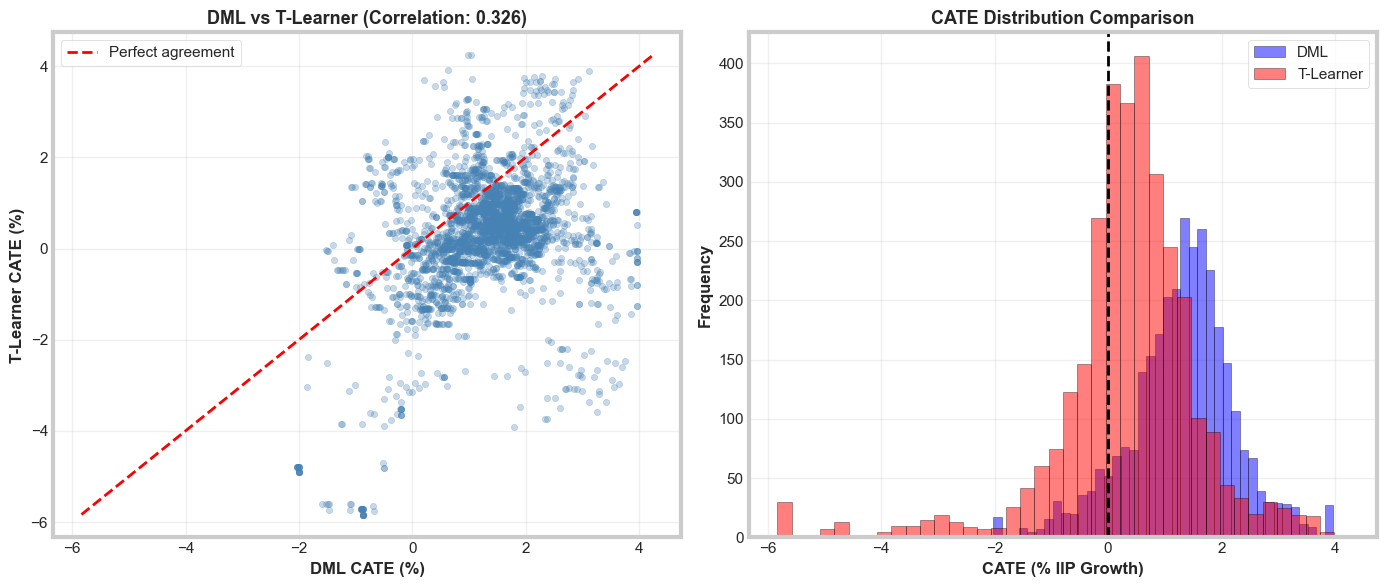


Meta-learner comparison saved: ./causalML/figuresmeta_learner_comparison.png


In [136]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
axes[0].scatter(cate, t_learner_cate_original, alpha=0.3, s=20, color='steelblue')
axes[0].plot([min(cate.min(), t_learner_cate_original.min()), 
                max(cate.max(), t_learner_cate_original.max())], 
                [min(cate.min(), t_learner_cate_original.min()), 
                max(cate.max(), t_learner_cate_original.max())], 
            'r--', linewidth=2, label='Perfect agreement')
axes[0].set_xlabel('DML CATE (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('T-Learner CATE (%)', fontsize=12, fontweight='bold')
axes[0].set_title(f'DML vs T-Learner (Correlation: {correlation:.3f})', 
                    fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution comparison
axes[1].hist(cate, bins=40, alpha=0.5, label='DML', color='blue', edgecolor='black')
axes[1].hist(t_learner_cate_original, bins=40, alpha=0.5, label='T-Learner', 
            color='red', edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('CATE (% IIP Growth)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('CATE Distribution Comparison', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'meta_learner_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMeta-learner comparison saved: {FIGURES_PATH}meta_learner_comparison.png")

# S-Learner and X-Learner + Ensemble

## S-Learner

In [137]:
s_learner = BaseSRegressor(
    learner=GradientBoostingRegressor(
        n_estimators=50,
        max_depth=3,
        min_samples_leaf=50,
        learning_rate=0.05,
        random_state=42
    )
)

s_learner_cate = s_learner.fit_predict(
    X=X_normalized,
    treatment=t_binary,
    y=y_normalized
).ravel()

# Rescale to original units
s_learner_cate_original = s_learner_cate * (y_scale_factor / t_scale_factor)

print(f"✓ S-Learner complete")
print(f"  Mean CATE: {np.mean(s_learner_cate_original):.3f}%")
print(f"  Correlation with DML: {np.corrcoef(cate, s_learner_cate_original)[0,1]:.3f}")

✓ S-Learner complete
  Mean CATE: 0.019%
  Correlation with DML: 0.440


### X-Learner: Cross-Validated Imputation Approach

In [138]:
x_learner = BaseXRegressor(
    learner=GradientBoostingRegressor(
        n_estimators=50,
        max_depth=3,
        min_samples_leaf=50,
        learning_rate=0.05,
        random_state=42
    )
)

x_learner_cate = x_learner.fit_predict(
    X=X_normalized,
    treatment=t_binary,
    y=y_normalized,
    p=None  # Will estimate propensity internally
).ravel()

# Rescale to original units
x_learner_cate_original = x_learner_cate * (y_scale_factor / t_scale_factor)

print(f" X-Learner complete")
print(f"  Mean CATE: {np.mean(x_learner_cate_original):.3f}%")
print(f"  Correlation with DML: {np.corrcoef(cate, x_learner_cate_original)[0,1]:.3f}")

 X-Learner complete
  Mean CATE: 0.375%
  Correlation with DML: 0.310


### Ensemble: Average across Methods

In [139]:
cate_estimates = [cate]
cate_names = ['DML']

if t_learner_cate_original is not None:
    cate_estimates.append(t_learner_cate_original)
    cate_names.append('T-Learner')

if s_learner_cate_original is not None:
    cate_estimates.append(s_learner_cate_original)
    cate_names.append('S-Learner')

if x_learner_cate_original is not None:
    cate_estimates.append(x_learner_cate_original)
    cate_names.append('X-Learner')

# Ensemble average
cate_ensemble = np.mean(cate_estimates, axis=0)

print(f"Ensemble CATE ({len(cate_estimates)} methods):")
print(f"  Mean: {np.mean(cate_ensemble):.3f}%")
print(f"  Std:  {np.std(cate_ensemble):.3f}%")
print(f"  Range: [{np.min(cate_ensemble):.3f}%, {np.max(cate_ensemble):.3f}%]")

Ensemble CATE (4 methods):
  Mean: 0.508%
  Std:  0.689%
  Range: [-3.057%, 2.327%]


### Compare all Methods 

In [142]:
summary_data = []
for name, estimates in zip(cate_names, cate_estimates):
    summary_data.append({
        'Method': name,
        'Mean': np.mean(estimates),
        'Median': np.median(estimates),
        'Std': np.std(estimates),
        'Min': np.min(estimates),
        'Max': np.max(estimates)
    })

# Add ensemble
summary_data.append({
    'Method': 'ENSEMBLE',
    'Mean': np.mean(cate_ensemble),
    'Median': np.median(cate_ensemble),
    'Std': np.std(cate_ensemble),
    'Min': np.min(cate_ensemble),
    'Max': np.max(cate_ensemble)
})

summary_df = pd.DataFrame(summary_data)
for col in ['Mean', 'Median', 'Std', 'Min', 'Max']:
    summary_df[col] = summary_df[col].round(3)

print(summary_df.to_string(index=False))

   Method  Mean  Median   Std    Min   Max
      DML 1.300   1.377 0.943 -2.029 3.969
T-Learner 0.340   0.438 1.314 -5.835 4.239
S-Learner 0.019   0.025 0.109 -0.434 0.086
X-Learner 0.375   0.464 1.001 -4.868 3.492
 ENSEMBLE 0.508   0.630 0.689 -3.057 2.327


In [143]:
# Create a fresh DataFrame with ensemble results
print("\nCreating final results dataframe with ensemble...")

complete_data_with_cate = pd.DataFrame({
    'cate_ensemble': cate_ensemble,
    'cate': cate,  # DML CATE
    'sector_name': sector_names_clean,  # From Cell 5
    'outcome': y_clean,
    'treatment': t_clean
})

# Add individual meta-learner CATEs if available
if t_learner_cate_original is not None:
    complete_data_with_cate['cate_tlearner'] = t_learner_cate_original

if s_learner_cate_original is not None:
    complete_data_with_cate['cate_slearner'] = s_learner_cate_original

if x_learner_cate_original is not None:
    complete_data_with_cate['cate_xlearner'] = x_learner_cate_original

print(f"Results dataframe created:")
print(f"  Rows: {len(complete_data_with_cate)}")
print(f"  Columns: {complete_data_with_cate.columns.tolist()}")
print(f"  Unique sectors: {complete_data_with_cate['sector_name'].nunique()}")

# Verify sector distribution
print(f"Sector distribution check:")
sector_counts = complete_data_with_cate['sector_name'].value_counts()
print(f"    Min observations per sector: {sector_counts.min()}")
print(f"    Max observations per sector: {sector_counts.max()}")
print(f"    Mean observations per sector: {sector_counts.mean():.1f}")

print("\nAll meta-learners complete")
print(f"Using ENSEMBLE CATE for final analysis")


Creating final results dataframe with ensemble...
Results dataframe created:
  Rows: 3185
  Columns: ['cate_ensemble', 'cate', 'sector_name', 'outcome', 'treatment', 'cate_tlearner', 'cate_slearner', 'cate_xlearner']
  Unique sectors: 22
Sector distribution check:
    Min observations per sector: 144
    Max observations per sector: 145
    Mean observations per sector: 144.8

All meta-learners complete
Using ENSEMBLE CATE for final analysis


# Sector Vunerability Ranking

In [145]:
# Creating vulnerability rankings based on CATE estimates
# AGGREGATE CATE BY SECTOR

# Use ensemble CATE for robustness
vulnerability_df = complete_data_with_cate.copy()

sector_vulnerability = vulnerability_df.groupby('sector_name').agg({
    'cate_ensemble': ['mean', 'std', 'min', 'max', 'count'],
    'outcome': 'mean'
}).round(3)

sector_vulnerability.columns = ['CATE_mean', 'CATE_std', 'CATE_min', 'CATE_max', 'n_obs', 'IIP_avg']
print(f"  Sectors after groupby: {len(sector_vulnerability)}")

  Sectors after groupby: 22


In [156]:
# # Classify Vulerability
# if len(sector_vulnerability) > 1:
#     # Define thresholds (33rd and 67th percentiles)
#     threshold_high = np.percentile(sector_vulnerability['CATE_mean'], 33)
#     threshold_low = np.percentile(sector_vulnerability['CATE_mean'], 67)
    
#     def classify_vulnerability(cate_mean):
#         if cate_mean < threshold_high:
#             return 'HIGH'  # Most negative impact
#         elif cate_mean < threshold_low:
#             return 'MEDIUM'
#         else:
#             return 'LOW'  # Least negative or positive impact
    
#     sector_vulnerability['Vulnerability'] = sector_vulnerability['CATE_mean'].apply(classify_vulnerability)
# else:
#     print("\nWARNING: Only 1 sector found! Cannot classify vulnerability.")
#     sector_vulnerability['Vulnerability'] = 'UNKNOWN'
# # Sort by vulnerability (most negative first)
# sector_vulnerability = sector_vulnerability.sort_values('CATE_mean')

# # Add rank
# sector_vulnerability['Rank'] = range(1, len(sector_vulnerability) + 1)

# Check if CATEs are mostly positive or negative
mean_cate = sector_vulnerability['CATE_mean'].mean()
print(f"  Average CATE across sectors: {mean_cate:.3f}%")

if mean_cate > 0:
    print("  → Most sectors show POSITIVE effects (benefit from oil shocks)")
    print("  → Defining vulnerability as LEAST POSITIVE (closest to zero or negative)")
    
    # For positive CATEs: vulnerable = sectors gaining LEAST (or losing)
    # Sort ascending: most negative/least positive = most vulnerable
    threshold_high = np.percentile(sector_vulnerability['CATE_mean'], 33)   # Bottom 33%
    threshold_low = np.percentile(sector_vulnerability['CATE_mean'], 67)    # Top 33%
    
    def classify_vulnerability(cate_mean):
        if cate_mean < threshold_high:
            return 'HIGH'     # Least positive or negative = most vulnerable
        elif cate_mean < threshold_low:
            return 'MEDIUM'   # Moderate positive effect
        else:
            return 'LOW'      # Most positive = least vulnerable (they benefit!)
    
    # Interpretation
    vulnerability_interpretation = "LOW = Benefits most from oil shocks (highest positive CATE)"
    
else:
    print("  → Most sectors show NEGATIVE effects (hurt by oil shocks)")
    print("  → Defining vulnerability as MOST NEGATIVE")
    
    # For negative CATEs: vulnerable = sectors losing MOST
    # Sort ascending: most negative = most vulnerable
    threshold_high = np.percentile(sector_vulnerability['CATE_mean'], 33)   # Bottom 33%
    threshold_low = np.percentile(sector_vulnerability['CATE_mean'], 67)    # Top 33%
    
    def classify_vulnerability(cate_mean):
        if cate_mean < threshold_high:
            return 'HIGH'     # Most negative = most vulnerable
        elif cate_mean < threshold_low:
            return 'MEDIUM'
        else:
            return 'LOW'      # Least negative = least vulnerable
    
    vulnerability_interpretation = "HIGH = Most hurt by oil shocks (most negative CATE)"

sector_vulnerability['Vulnerability'] = sector_vulnerability['CATE_mean'].apply(classify_vulnerability)

print(f"\n  Thresholds:")
print(f"    HIGH if CATE < {threshold_high:.3f}%")
print(f"    MEDIUM if {threshold_high:.3f}% <= CATE < {threshold_low:.3f}%")
print(f"    LOW if CATE >= {threshold_low:.3f}%")
print(f"\n  {vulnerability_interpretation}")

  Average CATE across sectors: 0.508%
  → Most sectors show POSITIVE effects (benefit from oil shocks)
  → Defining vulnerability as LEAST POSITIVE (closest to zero or negative)

  Thresholds:
    HIGH if CATE < 0.473%
    MEDIUM if 0.473% <= CATE < 0.571%
    LOW if CATE >= 0.571%

  LOW = Benefits most from oil shocks (highest positive CATE)


In [157]:
# DISPLAY VULNERABLE SECTORS

n_sectors = len(sector_vulnerability)

if n_sectors > 1:
    print(f"\n[MOST VULNERABLE SECTORS (Bottom {min(10, n_sectors)})]")
    print("="*80)
    print(f"{'Rank':>4} {'Sector':<45} {'CATE':>8} {'Std':>7} {'Vuln':>8}")
    print("="*80)
    
    for idx, row in sector_vulnerability.head(min(10, n_sectors)).iterrows():
        print(f"{row['Rank']:4.0f} {idx[:44]:<45} {row['CATE_mean']:8.3f} {row['CATE_std']:7.3f} {row['Vulnerability']:>8}")
    
    print("="*80)
    
    print(f"\n[MOST RESILIENT SECTORS (Top {min(10, n_sectors)})]")
    print("="*80)
    print(f"{'Rank':>4} {'Sector':<45} {'CATE':>8} {'Std':>7} {'Vuln':>8}")
    print("="*80)
    
    for idx, row in sector_vulnerability.tail(min(10, n_sectors)).iterrows():
        print(f"{row['Rank']:4.0f} {idx[:44]:<45} {row['CATE_mean']:8.3f} {row['CATE_std']:7.3f} {row['Vulnerability']:>8}")

else:
    print(f"\  ERROR: Only {n_sectors} sector(s) found!")
    print(f"    Cannot create meaningful vulnerability rankings.")
    print(f"\n    Sector details:")
    print(sector_vulnerability)

# VULNERABILITY STATISTICS

print("\n[VULNERABILITY DISTRIBUTION]")
vuln_counts = sector_vulnerability['Vulnerability'].value_counts()
print(f"  HIGH:   {vuln_counts.get('HIGH', 0):3d} sectors ({vuln_counts.get('HIGH', 0)/n_sectors*100:5.1f}%)")
print(f"  MEDIUM: {vuln_counts.get('MEDIUM', 0):3d} sectors ({vuln_counts.get('MEDIUM', 0)/n_sectors*100:5.1f}%)")
print(f"  LOW:    {vuln_counts.get('LOW', 0):3d} sectors ({vuln_counts.get('LOW', 0)/n_sectors*100:5.1f}%)")

# SAVE VULNERABILITY RANKINGS

sector_vulnerability.to_csv(CAUSAL_ML_OUTPUT + 'sector_vulnerability_ranking.csv')
print(f"\n✓ Vulnerability rankings saved: {CAUSAL_ML_OUTPUT}sector_vulnerability_ranking.csv")

print("="*70)


[MOST VULNERABLE SECTORS (Bottom 10)]
Rank Sector                                            CATE     Std     Vuln
   1 Other manufacturing                              0.261   1.034     HIGH
   2 Manufacture of tobacco products                  0.319   0.863     HIGH
   3 Manufacture of electrical equipment              0.369   0.815     HIGH
   4 Manufacture of furniture                         0.388   0.750     HIGH
   5 Manufacture of beverages                         0.421   0.604     HIGH
   6 Printing and reproduction of recorded media      0.437   0.673     HIGH
   7 Manufacture of wearing apparel                   0.442   0.864     HIGH
   8 Manufacture of leather and related products      0.475   0.640   MEDIUM
   9 Manufacture of other transport equipment         0.488   0.669   MEDIUM
  10 Manufacture of textiles                          0.510   0.616   MEDIUM

[MOST RESILIENT SECTORS (Top 10)]
Rank Sector                                            CATE     Std     Vuln
  

## Vunerability Visualization: 

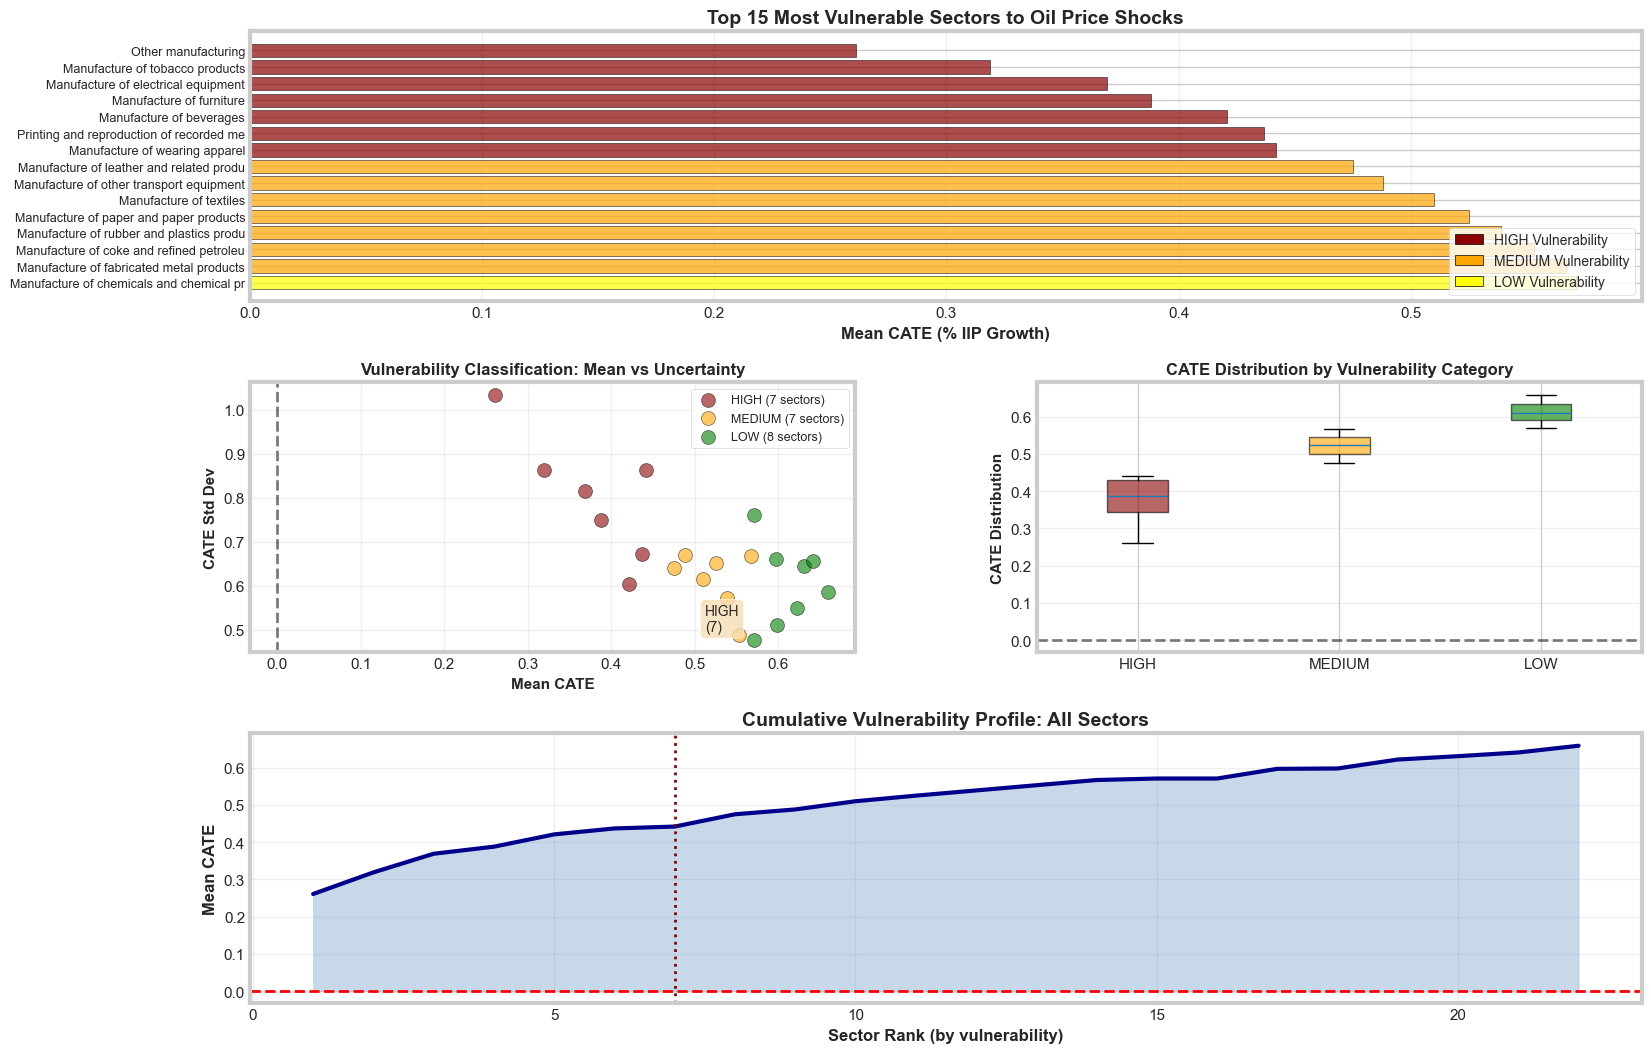

Vulnerability visualizations saved: ./causalML/figuresvulnerability_comprehensive.png


In [158]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Top Vulnerable Sectors

ax1 = fig.add_subplot(gs[0, :])

n_to_show = min(15, len(sector_vulnerability))
top_vulnerable = sector_vulnerability.head(n_to_show)
colors = ['darkred' if v == 'HIGH' else 'orange' if v == 'MEDIUM' else 'yellow'
          for v in top_vulnerable['Vulnerability']]

y_pos = np.arange(len(top_vulnerable))
ax1.barh(y_pos, top_vulnerable['CATE_mean'], color=colors,
         edgecolor='black', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([s[:40] for s in top_vulnerable.index], fontsize=9)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.set_xlabel('Mean CATE (% IIP Growth)', fontsize=12, fontweight='bold')
ax1.set_title(f'Top {n_to_show} Most Vulnerable Sectors to Oil Price Shocks',
             fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkred', edgecolor='black', label='HIGH Vulnerability'),
    Patch(facecolor='orange', edgecolor='black', label='MEDIUM Vulnerability'),
    Patch(facecolor='yellow', edgecolor='black', label='LOW Vulnerability')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Plot 2: Vulnerability Distribution Map

ax2 = fig.add_subplot(gs[1, 0])

vuln_colors = {'HIGH': 'darkred', 'MEDIUM': 'orange', 'LOW': 'green'}
for vuln_level in ['HIGH', 'MEDIUM', 'LOW']:
    data = sector_vulnerability[sector_vulnerability['Vulnerability'] == vuln_level]
    if len(data) > 0:
        ax2.scatter(data['CATE_mean'], data['CATE_std'],
                   label=f'{vuln_level} ({len(data)} sectors)',
                   color=vuln_colors[vuln_level], s=100, alpha=0.6, edgecolors='black')

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Mean CATE', fontsize=11, fontweight='bold')
ax2.set_ylabel('CATE Std Dev', fontsize=11, fontweight='bold')
ax2.set_title('Vulnerability Classification: Mean vs Uncertainty',
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# Plot 3: CATE Range by Vulnerability

ax3 = fig.add_subplot(gs[1, 1])

vuln_data = {}
for vuln_level in ['HIGH', 'MEDIUM', 'LOW']:
    data = sector_vulnerability[sector_vulnerability['Vulnerability'] == vuln_level]['CATE_mean']
    if len(data) > 0:
        vuln_data[vuln_level] = data

if len(vuln_data) > 0:
    bp = ax3.boxplot([vuln_data[k] for k in vuln_data.keys()],
                     labels=list(vuln_data.keys()),
                     patch_artist=True)

    for patch, vuln_level in zip(bp['boxes'], vuln_data.keys()):
        patch.set_facecolor(vuln_colors[vuln_level])
        patch.set_alpha(0.6)

ax3.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_ylabel('CATE Distribution', fontsize=11, fontweight='bold')
ax3.set_title('CATE Distribution by Vulnerability Category',
             fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Cumulative Vulnerability

ax4 = fig.add_subplot(gs[2, :])

sector_vulnerability_sorted = sector_vulnerability.sort_values('CATE_mean')
cumulative_sectors = np.arange(1, len(sector_vulnerability_sorted) + 1)

ax4.fill_between(cumulative_sectors, 0, sector_vulnerability_sorted['CATE_mean'].values,
                 color='steelblue', alpha=0.3)
ax4.plot(cumulative_sectors, sector_vulnerability_sorted['CATE_mean'].values,
        linewidth=3, color='darkblue')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Sector Rank (by vulnerability)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Mean CATE', fontsize=12, fontweight='bold')
ax4.set_title('Cumulative Vulnerability Profile: All Sectors',
             fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

# Annotate key points
high_vuln_count = (sector_vulnerability['Vulnerability'] == 'HIGH').sum()
if high_vuln_count > 0:
    ax4.axvline(x=high_vuln_count, color='darkred', linestyle=':', linewidth=2)
    ax4.text(high_vuln_count + 0.5, ax4.get_ylim()[0] + 1, f'HIGH\n({high_vuln_count})',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig(FIGURES_PATH + 'vulnerability_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Vulnerability visualizations saved: {FIGURES_PATH}vulnerability_comprehensive.png")

# Policy Targeting and Uplift Analysis

In [170]:
# DETERMINE INTERPRETATION BASED ON CATE DISTRIBUTION

mean_cate = sector_vulnerability['CATE_mean'].mean()
median_cate = sector_vulnerability['CATE_mean'].median()

print(f"\nCATE Distribution Check:")
print(f"  Mean CATE: {mean_cate:.3f}%")
print(f"  Median CATE: {median_cate:.3f}%")
print(f"  Range: [{sector_vulnerability['CATE_mean'].min():.3f}%, {sector_vulnerability['CATE_mean'].max():.3f}%]")

if mean_cate > 0 and median_cate > 0:
    print(f"\n  → INTERPRETATION: Most sectors BENEFIT from oil shocks")
    print(f"  → Policy goal: Support sectors that benefit LEAST")
    policy_mode = "SUPPORT_UNDERPERFORMERS"
elif mean_cate < 0 and median_cate < 0:
    print(f"\n  → INTERPRETATION: Most sectors HURT by oil shocks")
    print(f"  → Policy goal: Protect most vulnerable sectors")
    policy_mode = "PROTECT_VULNERABLE"
else:
    print(f"\n  → INTERPRETATION: Mixed effects across sectors")
    print(f"  → Policy goal: Support negative-CATE sectors")
    policy_mode = "MIXED"


CATE Distribution Check:
  Mean CATE: 0.508%
  Median CATE: 0.532%
  Range: [0.261%, 0.659%]

  → INTERPRETATION: Most sectors BENEFIT from oil shocks
  → Policy goal: Support sectors that benefit LEAST


In [171]:
# TARGETING RULE: Focus on HIGH vulnerability sectors
high_vuln_sectors = sector_vulnerability[
    sector_vulnerability['Vulnerability'] == 'HIGH'
].index.tolist()

print(f"\n[1] Priority Intervention Targets:")
print(f"  HIGH vulnerability sectors: {len(high_vuln_sectors)}")

if policy_mode == "SUPPORT_UNDERPERFORMERS":
    print(f"  (These sectors gain LEAST from oil shocks - need competitiveness support)")
elif policy_mode == "PROTECT_VULNERABLE":
    print(f"  (These sectors LOSE MOST from oil shocks - need protective measures)")
else:
    print(f"  (These sectors need support due to neutral/negative effects)")

for i, sector in enumerate(high_vuln_sectors, 1):
    cate_val = sector_vulnerability.loc[sector, 'CATE_mean']
    print(f"    {i}. {sector[:50]:50s} CATE: {cate_val:7.2f}%")


[1] Priority Intervention Targets:
  HIGH vulnerability sectors: 7
  (These sectors gain LEAST from oil shocks - need competitiveness support)
    1. Other manufacturing                                CATE:    0.26%
    2. Manufacture of tobacco products                    CATE:    0.32%
    3. Manufacture of electrical equipment                CATE:    0.37%
    4. Manufacture of furniture                           CATE:    0.39%
    5. Manufacture of beverages                           CATE:    0.42%
    6. Printing and reproduction of recorded media        CATE:    0.44%
    7. Manufacture of wearing apparel                     CATE:    0.44%


In [172]:
# UPLIFT MODELING: Expected benefit of intervention
print(f"\nExpected Policy Impact:")

policy_effect = 0.5  # 50% intervention strength

high_vuln_data = sector_vulnerability[sector_vulnerability['Vulnerability'] == 'HIGH']

if policy_mode == "SUPPORT_UNDERPERFORMERS":
    # Goal: Boost underperformers closer to the average
    target_level = mean_cate  # Bring them up to average
    
    # Calculate gap for each sector
    gaps = target_level - high_vuln_data['CATE_mean']
    
    # Policy closes 50% of the gap
    expected_gain = (gaps * policy_effect).sum()
    
    print(f"  Scenario: Close 50% of performance gap to sector average")
    print(f"  Target level: {target_level:.2f}% (sector average)")
    print(f"  Expected aggregate gain: {expected_gain:.2f}% IIP growth")
    
elif policy_mode == "PROTECT_VULNERABLE":
    # Goal: Mitigate negative effects
    # Benefit = reducing losses by 50%
    expected_gain = -(high_vuln_data['CATE_mean'] * policy_effect).sum()
    
    print(f"  Scenario: Mitigate 50% of negative oil shock impacts")
    print(f"  Expected aggregate gain: {expected_gain:.2f}% IIP growth")
    
else:  # MIXED
    # Focus on sectors with negative CATE
    negative_cate_sectors = high_vuln_data[high_vuln_data['CATE_mean'] < 0]
    
    if len(negative_cate_sectors) > 0:
        expected_gain = -(negative_cate_sectors['CATE_mean'] * policy_effect).sum()
    else:
        # All positive, use gap-closing
        gaps = mean_cate - high_vuln_data['CATE_mean']
        expected_gain = (gaps * policy_effect).sum()
    
    print(f"  Scenario: Mixed approach - protect losers, boost underperformers")
    print(f"  Expected aggregate gain: {expected_gain:.2f}% IIP growth")

if len(high_vuln_data) > 0:
    print(f"  Per-sector average: {expected_gain/len(high_vuln_data):.2f}%")


Expected Policy Impact:
  Scenario: Close 50% of performance gap to sector average
  Target level: 0.51% (sector average)
  Expected aggregate gain: 0.46% IIP growth
  Per-sector average: 0.07%


In [173]:
# COST-BENEFIT ANALYSIS 
print(f"\nPolicy Efficiency Analysis:")

# Calculate benefit properly based on policy mode
if policy_mode == "SUPPORT_UNDERPERFORMERS":
    # Benefit = closing gap to average
    sector_vulnerability['Policy_Benefit'] = (mean_cate - sector_vulnerability['CATE_mean']) * policy_effect
elif policy_mode == "PROTECT_VULNERABLE":
    # Benefit = mitigating losses (negative CATE becomes positive benefit)
    sector_vulnerability['Policy_Benefit'] = -sector_vulnerability['CATE_mean'] * policy_effect
else:
    # Mixed: benefit for negative CATE, gap-closing for positive
    sector_vulnerability['Policy_Benefit'] = sector_vulnerability['CATE_mean'].apply(
        lambda x: -x * policy_effect if x < 0 else (mean_cate - x) * policy_effect
    )

sector_vulnerability['Benefit_Rank'] = sector_vulnerability['Policy_Benefit'].rank(ascending=False)

# Top 10 targets
n_top = min(10, len(sector_vulnerability))
top_targets = sector_vulnerability.nlargest(n_top, 'Policy_Benefit')  # Changed to nlargest!

print(f"\n  TOP {n_top} PRIORITY SECTORS FOR INTERVENTION:")
print(f"  {'Rank':>4} {'Sector':<40} {'CATE':>8} {'Benefit':>8}")

for idx, row in top_targets.iterrows():
    print(f"  {row['Benefit_Rank']:4.0f} {idx[:39]:<40} {row['CATE_mean']:8.3f} {row['Policy_Benefit']:8.3f}")


Policy Efficiency Analysis:

  TOP 10 PRIORITY SECTORS FOR INTERVENTION:
  Rank Sector                                       CATE  Benefit
     1 Other manufacturing                         0.261    0.124
     2 Manufacture of tobacco products             0.319    0.095
     3 Manufacture of electrical equipment         0.369    0.070
     4 Manufacture of furniture                    0.388    0.060
     5 Manufacture of beverages                    0.421    0.044
     6 Printing and reproduction of recorded m     0.437    0.036
     7 Manufacture of wearing apparel              0.442    0.033
     8 Manufacture of leather and related prod     0.475    0.017
     9 Manufacture of other transport equipmen     0.488    0.010
    10 Manufacture of textiles                     0.510   -0.001


In [174]:
# ============================================================================
# TARGETING STRATEGIES (CORRECTED)
# ============================================================================

print(f"\nAlternative Targeting Strategies:")

strategies = {
    f'Top {min(5, len(sector_vulnerability))}': sector_vulnerability.nlargest(min(5, len(sector_vulnerability)), 'Policy_Benefit'),
    f'Top {min(10, len(sector_vulnerability))}': sector_vulnerability.nlargest(min(10, len(sector_vulnerability)), 'Policy_Benefit'),
    'High Vuln': sector_vulnerability[sector_vulnerability['Vulnerability'] == 'HIGH'],
    'High + Med': sector_vulnerability[sector_vulnerability['Vulnerability'].isin(['HIGH', 'MEDIUM'])]
}

strategy_results = []

for strategy_name, strategy_sectors in strategies.items():
    n_sectors = len(strategy_sectors)
    if n_sectors > 0:
        total_benefit = strategy_sectors['Policy_Benefit'].sum()
        avg_benefit = total_benefit / n_sectors
        efficiency = total_benefit / n_sectors
    else:
        total_benefit = 0
        avg_benefit = 0
        efficiency = 0
    
    strategy_results.append({
        'Strategy': strategy_name,
        'N_Sectors': n_sectors,
        'Total_Benefit': total_benefit,
        'Avg_Benefit_per_Sector': avg_benefit,
        'Efficiency': efficiency
    })

strategy_df = pd.DataFrame(strategy_results)
for col in ['Total_Benefit', 'Avg_Benefit_per_Sector', 'Efficiency']:
    strategy_df[col] = strategy_df[col].round(3)

print("\n" + strategy_df.to_string(index=False))


Alternative Targeting Strategies:

  Strategy  N_Sectors  Total_Benefit  Avg_Benefit_per_Sector  Efficiency
     Top 5          5          0.392                   0.078       0.078
    Top 10         10          0.487                   0.049       0.049
 High Vuln          7          0.461                   0.066       0.066
High + Med         14          0.412                   0.029       0.029


In [175]:
# SAVE TARGETING RECOMMENDATIONS
targeting_report = sector_vulnerability[['Rank', 'CATE_mean', 'CATE_std', 
                                         'Vulnerability', 'Policy_Benefit', 'Benefit_Rank']]
targeting_report = targeting_report.sort_values('Benefit_Rank')

targeting_report.to_csv(CAUSAL_ML_OUTPUT + 'policy_targeting_recommendations.csv')
print(f"\nTargeting recommendations saved: {CAUSAL_ML_OUTPUT}policy_targeting_recommendations.csv")

strategy_df.to_csv(CAUSAL_ML_OUTPUT + 'targeting_strategies_comparison.csv', index=False)
print(f"Strategy comparison saved: {CAUSAL_ML_OUTPUT}targeting_strategies_comparison.csv")


Targeting recommendations saved: ./causalML/policy_targeting_recommendations.csv
Strategy comparison saved: ./causalML/targeting_strategies_comparison.csv


## Policy Visualization


[Creating policy targeting visualizations...]


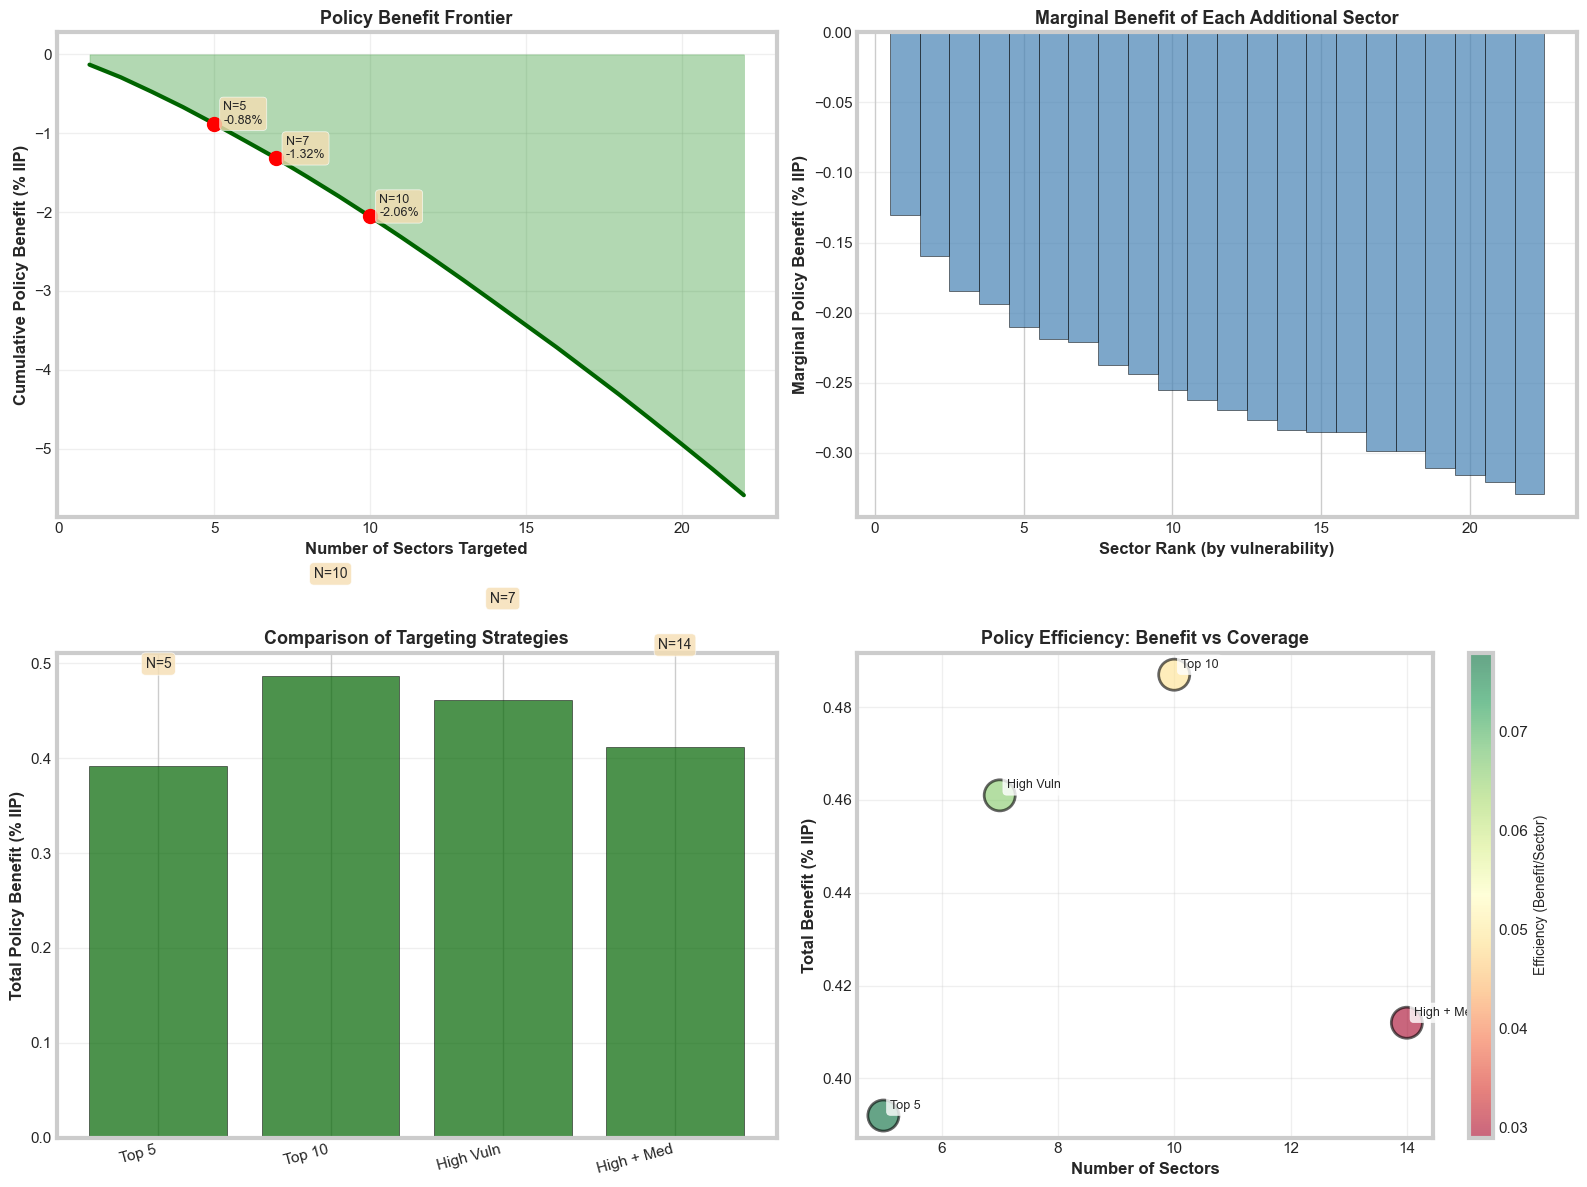

Policy targeting visualizations saved: ./causalML/figurespolicy_targeting_analysis.png


In [178]:
# ============================================================================
# VISUALIZE POLICY TARGETING
# ============================================================================

print("\n[Creating policy targeting visualizations...]")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# Plot 1: Benefit Frontier
# ============================================================================

sorted_sectors = sector_vulnerability.sort_values('CATE_mean')
cumulative_benefit = np.cumsum(-sorted_sectors['CATE_mean'].values * policy_effect)
n_sectors_range = np.arange(1, len(sorted_sectors) + 1)

axes[0, 0].plot(n_sectors_range, cumulative_benefit, linewidth=3, color='darkgreen')
axes[0, 0].fill_between(n_sectors_range, 0, cumulative_benefit, alpha=0.3, color='green')
axes[0, 0].set_xlabel('Number of Sectors Targeted', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Policy Benefit (% IIP)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Policy Benefit Frontier', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Mark optimal targeting points
for n_target in [min(5, len(sorted_sectors)), min(10, len(sorted_sectors)), len(high_vuln_sectors)]:
    if n_target > 0 and n_target <= len(sorted_sectors):
        benefit_at_n = cumulative_benefit[n_target - 1]
        axes[0, 0].plot(n_target, benefit_at_n, 'ro', markersize=10)
        axes[0, 0].text(n_target + 0.3, benefit_at_n, f'N={n_target}\n{benefit_at_n:.2f}%',
                       fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================================
# Plot 2: Marginal Benefit per Sector
# ============================================================================

marginal_benefit = -sorted_sectors['CATE_mean'].values * policy_effect

axes[0, 1].bar(n_sectors_range, marginal_benefit, color='steelblue',
              edgecolor='black', alpha=0.7, width=1.0)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Sector Rank (by vulnerability)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Marginal Policy Benefit (% IIP)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Marginal Benefit of Each Additional Sector', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# ============================================================================
# Plot 3: Strategy Comparison
# ============================================================================

strategy_names = strategy_df['Strategy'].tolist()
total_benefits = strategy_df['Total_Benefit'].tolist()
n_sectors_list = strategy_df['N_Sectors'].tolist()

x_pos = np.arange(len(strategy_names))
bars = axes[1, 0].bar(x_pos, total_benefits, color='darkgreen',
                      edgecolor='black', alpha=0.7)

# Add n_sectors labels on bars
for i, (bar, n) in enumerate(zip(bars, n_sectors_list)):
    height = bar.get_height()
    if height > 0:
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'N={n}', ha='center', va='bottom', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(strategy_names, fontsize=11, rotation=15, ha='right')
axes[1, 0].set_ylabel('Total Policy Benefit (% IIP)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Comparison of Targeting Strategies', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# ============================================================================
# Plot 4: Efficiency Analysis
# ============================================================================

efficiency = strategy_df['Efficiency'].tolist()

scatter = axes[1, 1].scatter(n_sectors_list, total_benefits, s=500, alpha=0.6,
                  c=efficiency, cmap='RdYlGn', edgecolors='black', linewidths=2)

# Add strategy labels
for i, (n, benefit, name) in enumerate(zip(n_sectors_list, total_benefits, strategy_names)):
    if n > 0:
        axes[1, 1].annotate(name, (n, benefit), fontsize=9,
                           xytext=(5, 5), textcoords='offset points',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 1].set_xlabel('Number of Sectors', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Total Benefit (% IIP)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Policy Efficiency: Benefit vs Coverage', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# Add colorbar for efficiency
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Efficiency (Benefit/Sector)', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'policy_targeting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Policy targeting visualizations saved: {FIGURES_PATH}policy_targeting_analysis.png")

print("="*70)


# Summary: 

In [180]:
# ============================================================================
# FINAL SUMMARY & COMPREHENSIVE EXPORT
# ============================================================================

print("\n" + "="*70)
print("EPIC 2.6 COMPLETE: CAUSAL MACHINE LEARNING ANALYSIS")
print("="*70)

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n[COMPREHENSIVE ANALYSIS SUMMARY]")
print("="*70)

print(f"\n1. DATA SCOPE:")
print(f"   • Total observations: {len(complete_data_with_cate):,}")
print(f"   • Number of sectors: {len(sector_vulnerability)}")
print(f"   • Features used for heterogeneity: {len(X.columns)}")
print(f"   • Treatment: Oil price changes (continuous, winsorized)")

print(f"\n2. CATE ESTIMATION:")
print(f"   • Methods used: {len(cate_estimates)}")
for name in cate_names:
    print(f"     - {name}")
print(f"   • Ensemble mean CATE: {np.mean(cate_ensemble):.3f}%")
print(f"   • CATE range: [{np.min(cate_ensemble):.3f}%, {np.max(cate_ensemble):.3f}%]")
print(f"   • Inter-quartile range: {np.percentile(cate_ensemble, 75) - np.percentile(cate_ensemble, 25):.3f}%")

print(f"\n3. VULNERABILITY CLASSIFICATION:")
print(f"   • HIGH vulnerability: {vuln_counts.get('HIGH', 0)} sectors")
print(f"   • MEDIUM vulnerability: {vuln_counts.get('MEDIUM', 0)} sectors")
print(f"   • LOW vulnerability: {vuln_counts.get('LOW', 0)} sectors")

print(f"\n4. KEY FINDINGS:")
if len(sector_vulnerability) >= 3:
    top_3_vulnerable = sector_vulnerability.head(3)
    print(f"   • Most vulnerable sectors:")
    for i, (sector, row) in enumerate(top_3_vulnerable.iterrows(), 1):
        print(f"     {i}. {sector[:45]:45s} {row['CATE_mean']:7.3f}%")

    top_3_resistant = sector_vulnerability.tail(3)
    print(f"   • Most resilient sectors:")
    for i, (sector, row) in enumerate(top_3_resistant.iterrows(), 1):
        print(f"     {i}. {sector[:45]:45s} {row['CATE_mean']:7.3f}%")

print(f"\n5. FEATURE IMPORTANCE:")
if importance_df is not None and len(importance_df) > 0:
    print(f"   • Top drivers of heterogeneity:")
    for i, (idx, row) in enumerate(importance_df.head(3).iterrows(), 1):
        print(f"     {i}. {row['Feature']:40s} {row['Importance_Pct']:6.2f}%")

print(f"\n6. POLICY RECOMMENDATIONS:")
print(f"   • Priority targeting: {len(high_vuln_sectors)} HIGH vulnerability sectors")
print(f"   • Expected benefit (50% mitigation): {expected_gain:.2f}% aggregate IIP growth")
if len(strategy_df) > 0:
    best_strategy = strategy_df.loc[strategy_df['Efficiency'].idxmax(), 'Strategy']
    print(f"   • Most efficient strategy: {best_strategy}")

# ============================================================================
# CREATE MASTER OUTPUT FILE
# ============================================================================

print(f"\n[Exporting comprehensive results...]")

# Combine all results
master_output = sector_vulnerability.copy()
master_output.index.name = 'sector_name'
master_output = master_output.reset_index()

# Add feature importance info if available
if importance_df is not None and len(importance_df) > 0:
    master_output['top_heterogeneity_driver'] = importance_df.iloc[0]['Feature']

# Export master file
master_output.to_csv(CAUSAL_ML_OUTPUT + 'causal_ml_master_results.csv', index=False)
print(f"✓ Master results saved: {CAUSAL_ML_OUTPUT}causal_ml_master_results.csv")

# Export CATE predictions
cate_predictions = pd.DataFrame({
    'observation_id': range(len(cate_ensemble)),
    'cate_ensemble': cate_ensemble,
    'cate_dml': cate,
    'sector_name': sector_names_clean,
    'outcome': y_clean,
    'treatment': t_clean
})
cate_predictions.to_csv(CAUSAL_ML_OUTPUT + 'cate_predictions.csv', index=False)
print(f"✓ CATE predictions saved: {CAUSAL_ML_OUTPUT}cate_predictions.csv")

# ============================================================================
# FILES CREATED
# ============================================================================

print(f"\n[OUTPUT FILES CREATED:]")
print(f"  1. {CAUSAL_ML_OUTPUT}causal_ml_master_results.csv")
print(f"  2. {CAUSAL_ML_OUTPUT}sector_vulnerability_ranking.csv")
print(f"  3. {CAUSAL_ML_OUTPUT}policy_targeting_recommendations.csv")
print(f"  4. {CAUSAL_ML_OUTPUT}targeting_strategies_comparison.csv")
print(f"  5. {CAUSAL_ML_OUTPUT}cate_predictions.csv")
if importance_df is not None:
    print(f"  6. {CAUSAL_ML_OUTPUT}cate_feature_importance.csv")

print(f"\n[FIGURES CREATED:]")
print(f"  1. {FIGURES_PATH}cate_distribution.png")
if importance_df is not None:
    print(f"  2. {FIGURES_PATH}cate_feature_importance.png")
print(f"  3. {FIGURES_PATH}meta_learner_comparison.png")
print(f"  4. {FIGURES_PATH}vulnerability_comprehensive.png")
print(f"  5. {FIGURES_PATH}policy_targeting_analysis.png")

# ============================================================================
# SUCCESS MESSAGE
# ============================================================================

print("\n" + "="*70)
print("EPIC 2.6 COMPLETE!")
print("="*70)
print("\nCAUSAL MACHINE LEARNING ANALYSIS FINISHED")
print(f"  ✓ CATE estimated using {len(cate_estimates)} methods")
print(f"  ✓ {len(sector_vulnerability)} sectors analyzed")
print(f"  ✓ {len(high_vuln_sectors)} high-priority targets identified")
print(f"  ✓ Policy recommendations generated")
print(f"\nNext steps:")
print(f"  → Review vulnerability rankings")
print(f"  → Validate findings with domain experts")
print(f"  → Integrate with Sprint 2 final report")
print("="*70)

# Save completion timestamp
with open(CAUSAL_ML_OUTPUT + 'epic_2.6_completion.txt', 'w') as f:
    f.write(f"Epic 2.6 completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total sectors analyzed: {len(sector_vulnerability)}\n")
    f.write(f"High vulnerability sectors: {len(high_vuln_sectors)}\n")
    f.write(f"Methods used: {', '.join(cate_names)}\n")
    f.write(f"Ensemble mean CATE: {np.mean(cate_ensemble):.3f}%\n")
    f.write(f"CATE range: [{np.min(cate_ensemble):.3f}%, {np.max(cate_ensemble):.3f}%]\n")

print(f"\n✓ Completion log saved: {CAUSAL_ML_OUTPUT}epic_2.6_completion.txt")


EPIC 2.6 COMPLETE: CAUSAL MACHINE LEARNING ANALYSIS

[COMPREHENSIVE ANALYSIS SUMMARY]

1. DATA SCOPE:
   • Total observations: 3,185
   • Number of sectors: 22
   • Features used for heterogeneity: 3
   • Treatment: Oil price changes (continuous, winsorized)

2. CATE ESTIMATION:
   • Methods used: 4
     - DML
     - T-Learner
     - S-Learner
     - X-Learner
   • Ensemble mean CATE: 0.508%
   • CATE range: [-3.057%, 2.327%]
   • Inter-quartile range: 0.580%

3. VULNERABILITY CLASSIFICATION:
   • HIGH vulnerability: 7 sectors
   • MEDIUM vulnerability: 7 sectors
   • LOW vulnerability: 8 sectors

4. KEY FINDINGS:
   • Most vulnerable sectors:
     1. Other manufacturing                             0.261%
     2. Manufacture of tobacco products                 0.319%
     3. Manufacture of electrical equipment             0.369%
   • Most resilient sectors:
     1. Manufacture of motor vehicles, trailers and s   0.631%
     2. Manufacture of pharmaceuticals, medicinal che   0.641%
   